# Chronicle Flood Database Intersection with MERIT Hydro dataset

This notebook provides a comprehensive analysis of the Chronicle urban flood dataset, containing over 880,000 flood events worldwide from 2000-2025.


## Hydro-merit upa index:

In [11]:
# ============================================
# 0) IMPORTS
# ============================================
import os
import math
import pandas as pd
import geopandas as gpd
from shapely import wkt

import ee
import geemap


# ============================================
# 1) CONFIGURATION
# ============================================
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"
GEOM_WKT_COL = "geometry_wkt"

# Earth Engine dataset
MERIT_IMAGE_ID = "MERIT/Hydro/v1_0_1"
UPA_BAND = "upa"  # upstream drainage area (km^2)

# Batch settings
BATCH_SIZE = 2000
START_BATCH_INDEX = 0
N_BATCHES_MAX = 5  # run at most 5 batches

# Zonal stats settings
SCALE_M = 90

# Output settings
OUT_DIR = r"D:\Development\RESEARCH\urban_flood_database\chronicle\pfdi_merit_outputs"
OUT_STATS_CSV = os.path.join(OUT_DIR, "pfdi_stats_first_5_batches.csv")
OUT_ENRICHED_PKL = os.path.join(OUT_DIR, "chronicle_urban_df_with_pfdi_first_5_batches.pkl")

# Map preview
SHOW_MAP_PREVIEW = True
MAP_CENTER = (20, 0)
MAP_ZOOM = 2


# ============================================
# 2) HELPERS
# ============================================
def ensure_out_dir(path):
    """Create output directory if it doesn't exist."""
    if not os.path.exists(path):
        os.makedirs(path, exist_ok=True)


def fix_geometry_safe(geom):
    """Fix minor geometry issues; returns original geometry if fix fails."""
    try:
        if geom is None:
            return None
        return geom.buffer(0)
    except Exception:
        return geom


def add_event_id(df_in):
    """Add stable integer event_id based on the DataFrame index."""
    df_out = df_in.copy()
    df_out["event_id"] = df_out.index.astype(int)
    return df_out


def compute_area_km2(gdf_wgs84):
    """Compute polygon area in km^2 using an equal-area CRS."""
    gdf_area = gdf_wgs84.to_crs("EPSG:6933").copy()
    return (gdf_area.geometry.area / 1_000_000.0).astype(float)


def ee_fc_to_df(fc):
    """Convert an EE FeatureCollection to a pandas DataFrame with robust fallbacks."""
    if hasattr(geemap, "ee_to_df"):
        return geemap.ee_to_df(fc)

    if hasattr(geemap, "ee_to_pandas"):
        return geemap.ee_to_pandas(fc)

    # Fallback: pull features client-side (slower, but robust for small batches)
    features = fc.getInfo().get("features", [])
    rows = [f.get("properties", {}) for f in features]
    return pd.DataFrame(rows)


def initialize_ee():
    """Initialize Earth Engine; authenticate interactively if needed."""
    try:
        ee.Initialize()
        print("Earth Engine initialized.")
    except Exception:
        print("Earth Engine not initialized. Running authentication...")
        ee.Authenticate()
        ee.Initialize()
        print("Earth Engine authenticated and initialized.")


def pick_stat_column(columns, preferred, fallback):
    """Pick a column name from EE output (supports with/without band prefix)."""
    if preferred in columns:
        return preferred
    if fallback in columns:
        return fallback
    return None


# ============================================
# 3) AUTHENTICATE & INITIALIZE EARTH ENGINE
# ============================================
initialize_ee()


# ============================================
# 4) LOAD PKL AND PREPARE GEODATAFRAME
# ============================================
ensure_out_dir(OUT_DIR)

df = pd.read_pickle(PKL_PATH)
df = add_event_id(df)

if GEOM_WKT_COL not in df.columns:
    raise ValueError(f"Column '{GEOM_WKT_COL}' not found. Available columns: {list(df.columns)}")

gdf = gpd.GeoDataFrame(
    df,
    geometry=df[GEOM_WKT_COL].apply(wkt.loads),
    crs="EPSG:4326"
)

gdf["geometry"] = gdf["geometry"].apply(fix_geometry_safe)
gdf = gdf[gdf.geometry.notnull()].copy()

gdf_min = gdf[["event_id", "geometry"]].copy()
gdf_min["poly_area_km2"] = compute_area_km2(gdf_min)

print("Chronicle GeoDataFrame loaded.")
print("Rows:", len(gdf_min))
print("CRS:", gdf_min.crs)
print(gdf_min[["event_id", "poly_area_km2"]].head())


# ============================================
# 5) LOAD MERIT HYDRO (UPA) AND DISPLAY ON A MAP (ONCE)
# ============================================
merit = ee.Image(MERIT_IMAGE_ID)
upa = merit.select(UPA_BAND)

if SHOW_MAP_PREVIEW:
    m = geemap.Map(center=MAP_CENTER, zoom=MAP_ZOOM)

    # Log visualization for intuition
    upa_log = upa.log10()
    vis_params = {"min": 0, "max": 5}

    m.addLayer(upa_log, vis_params, "MERIT Hydro - log10(UPA)")
    m.addLayerControl()
    m


# ============================================
# 6) DEFINE REDUCER FOR ZONAL STATS
# ============================================
reducer = ee.Reducer.max().combine(
    ee.Reducer.percentile([95, 99]),
    sharedInputs=True
)


# ============================================
# 7) RUN FIRST 5 BATCHES AND COMPUTE PFDI
# ============================================
n_rows = len(gdf_min)
n_batches_total = int(math.ceil(n_rows / float(BATCH_SIZE)))
n_batches = min(n_batches_total, int(N_BATCHES_MAX))

print(f"Planned batches: {n_batches} / {n_batches_total} total")
print("Batch size:", BATCH_SIZE)

batch_outputs = []

for batch_i in range(START_BATCH_INDEX, START_BATCH_INDEX + n_batches):
    i0 = batch_i * BATCH_SIZE
    i1 = min((batch_i + 1) * BATCH_SIZE, n_rows)

    gdf_batch = gdf_min.iloc[i0:i1].copy()

    # Convert batch polygons to EE FeatureCollection
    fc = geemap.geopandas_to_ee(gdf_batch[["event_id", "geometry"]])

    # Compute zonal stats (note: reduceRegions does NOT support bestEffort)
    stats_fc = upa.reduceRegions(
        collection=fc,
        reducer=reducer,
        scale=SCALE_M
    )

    df_stats = ee_fc_to_df(stats_fc)

    # Merge local area
    df_area = gdf_batch[["event_id", "poly_area_km2"]].copy()
    out = df_stats.merge(df_area, on="event_id", how="left")

    # Handle EE output column naming differences
    max_col = pick_stat_column(out.columns, "upa_max", "max")
    p95_col = pick_stat_column(out.columns, "upa_p95", "p95")
    p99_col = pick_stat_column(out.columns, "upa_p99", "p99")

    if p95_col is None:
        raise ValueError(f"Missing p95 column in batch output. Columns: {list(out.columns)}")

    # Compute PFDI (Pluvial–Fluvial Dominance Index)
    out["PFDI"] = out[p95_col] / out["poly_area_km2"]

    # Standardize column names
    rename_map = {}
    if max_col is not None:
        rename_map[max_col] = "upa_max"
    if p95_col is not None:
        rename_map[p95_col] = "upa_p95"
    if p99_col is not None:
        rename_map[p99_col] = "upa_p99"
    out = out.rename(columns=rename_map)

    # Keep a clean set of columns
    keep_cols = ["event_id", "poly_area_km2", "upa_max", "upa_p95", "upa_p99", "PFDI"]
    keep_cols = [c for c in keep_cols if c in out.columns]
    out = out[keep_cols].copy()

    # Save partial result
    partial_path = os.path.join(OUT_DIR, f"pfdi_stats_batch_{batch_i:04d}.csv")
    out.to_csv(partial_path, index=False)

    batch_outputs.append(out)

    print(f"Finished batch {batch_i + 1}/{START_BATCH_INDEX + n_batches}  Rows {i0}:{i1}  Saved: {os.path.basename(partial_path)}")


# ============================================
# 8) CONCAT RESULTS FROM FIRST 5 BATCHES AND SAVE
# ============================================
df_pfdi_stats = pd.concat(batch_outputs, ignore_index=True)
df_pfdi_stats.to_csv(OUT_STATS_CSV, index=False)

print("Saved combined stats table:", OUT_STATS_CSV)
print(df_pfdi_stats.head())


# ============================================
# 9) MERGE PFDI BACK INTO THE ORIGINAL PKL (FIRST 5 BATCHES ONLY) AND SAVE
# ============================================
df_orig = pd.read_pickle(PKL_PATH)
df_orig = add_event_id(df_orig)

df_enriched = df_orig.merge(df_pfdi_stats, on="event_id", how="left")
df_enriched.to_pickle(OUT_ENRICHED_PKL)

print("Saved enriched PKL (first 5 batches only):", OUT_ENRICHED_PKL)
print(df_enriched[["event_id", "PFDI"]].head())


Earth Engine not initialized. Running authentication...


Enter verification code: 4/1ASc3gC2QVeX3um8CBNtyD5jrTzB4DSFeGgWlJTx05Apoy4ldW45sP5kFq7c

Successfully saved authorization token.
Earth Engine authenticated and initialized.


KeyboardInterrupt: 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Paths (your local machine)
# =========================
CSV_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\pfdi_merit_outputs\pfdi_stats_batch_0000.csv"
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"

# =========================
# Load Data
# =========================
df_pfdi_raw = pd.read_csv(CSV_PATH)
df_orig = pd.read_pickle(PKL_PATH)

# Ensure the join key is consistent
df_orig["event_id"] = df_orig.index.astype(int)

# =========================
# Merge & Clean
# =========================
# Merge PFDI stats back to the original Chronicle data
# Using "inner" join to keep only rows that have calculated stats
df_pfdi_clean = df_orig.merge(df_pfdi_raw, on="event_id", how="inner").copy()

# Replace infinite values with NaN to prevent errors
df_pfdi_clean = df_pfdi_clean.replace([np.inf, -np.inf], np.nan)

# Drop rows where critical data (PFDI or Area) is missing
df_pfdi_clean = df_pfdi_clean.dropna(subset=["PFDI", "poly_area_km2"]).copy()

# Filter for strictly positive values (required for log-scale plotting later)
df_pfdi_clean = df_pfdi_clean[
    (df_pfdi_clean["PFDI"] > 0) & 
    (df_pfdi_clean["poly_area_km2"] > 0)
].copy()

df_pfdi_clean

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage,event_id,poly_area_km2,upa_max,upa_p95,upa_p99,PFDI
0,0,93e48341dbaa4be29a38b856d94206c5,191.436317,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.6844751 33.499789, -7.5516781 33....",4608358.0,1.531473e+08,3.009102,0,152.737360,2144.798828,0.231797,506.047577,0.001518
1,1,939149831ea34c3e94712cc42c17c46a,14.208894,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.9863739 29.745153, -7.9965878 29....",751304.0,9.880934e+06,7.603573,1,9.846162,1930.907593,24.820149,1929.830884,2.520794
2,2,931831f75479454cb3938811e64ce882,28.562733,v3.1,946684800.0,946684800.0,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...",3757833.0,1.180029e+07,31.845253,2,11.730829,8171.314453,0.613581,0.613581,0.052305
3,3,91bc68dde43646289c9e75b7d59e1711,108.562378,v3.1,946684800.0,946684800.0,1,"POLYGON ((30.936502 -29.872152, 30.928104 -29....",26634641.0,1.273836e+08,20.908999,3,126.937144,4441.062012,0.377705,243.834593,0.002976
4,4,8b849511de80423f98918f55af323e7e,0.104375,v3.1,946684800.0,946684800.0,1,"POLYGON ((16.547385 38.687964, 16.549982 38.68...",49138.0,1.051849e+05,46.715826,4,0.105030,0.107175,0.073682,0.073682,0.701532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,bc9db259939b4e7bbd733cddc75fd4ae,6.064658,v3.1,988675200.0,988675200.0,1,"POLYGON ((30.422276 50.489059, 30.451731 50.50...",986878.0,4.863141e+06,20.293018,1995,4.869447,12.263927,0.671918,11.538102,0.137987
1996,1996,cc7de4222d284f44875f88ec1c9e4886,39.465225,v3.1,988675200.0,988675200.0,1,"POLYGON ((37.71646 44.735583, 37.727298 44.768...",9056884.0,3.537692e+07,25.601112,1996,35.369374,84.639458,1.729812,37.736286,0.048907
1997,1997,ce5d434568224af895ac108113de7ca0,14.710346,v3.1,988675200.0,988675200.0,1,"POLYGON ((39.048374 44.12004, 39.087667 44.128...",2577571.0,1.484113e+07,17.367751,1997,14.839106,352.425598,0.082846,345.308260,0.005583
1998,1998,d4a1d64ccdc34b68b91d97921689b305,15.122304,v3.1,988675200.0,988675200.0,1,"POLYGON ((37.34507 45.276124, 37.363655 45.297...",4094533.0,2.473481e+07,16.553727,1998,24.727607,3562.722168,0.075580,3561.036632,0.003056


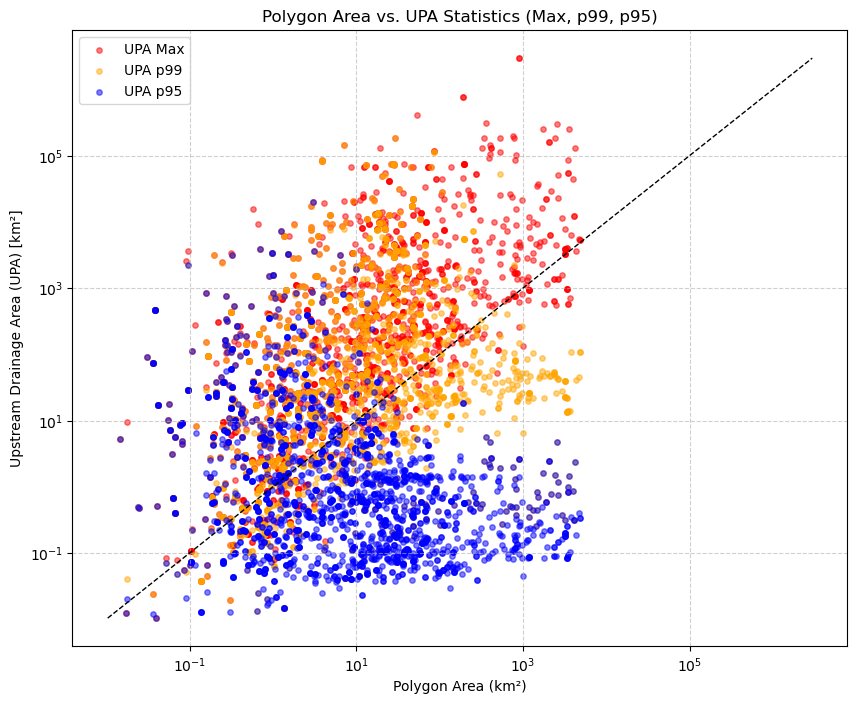

In [13]:
# =========================
# Plotting
# =========================
plt.figure(figsize=(10, 8))

# Define X axis data
x = df_pfdi_clean["poly_area_km2"]

# Plot UPA Max (Red) - Plotted first as it is likely the largest value
plt.scatter(
    x, 
    df_pfdi_clean["upa_max"], 
    color='red', 
    alpha=0.5, 
    label='UPA Max', 
    s=15
)

# Plot UPA p99 (Orange)
plt.scatter(
    x, 
    df_pfdi_clean["upa_p99"], 
    color='orange', 
    alpha=0.5, 
    label='UPA p99', 
    s=15
)

# Plot UPA p95 (Blue) - Plotted last to be on top
plt.scatter(
    x, 
    df_pfdi_clean["upa_p95"], 
    color='blue', 
    alpha=0.5, 
    label='UPA p95', 
    s=15
)

# =========================
# Formatting
# =========================
plt.xlabel("Polygon Area (km²)")
plt.ylabel("Upstream Drainage Area (UPA) [km²]")
plt.title("Polygon Area vs. UPA Statistics (Max, p99, p95)")
plt.legend()
plt.grid(True, which="both", linestyle="--", alpha=0.6)

# Log-log scale is essential for hydrological area data
plt.xscale("log")
plt.yscale("log")

# Optional: Add a 1:1 identity line for reference
# Points below this line have UPA < Area (Local rain / Pluvial)
# Points above this line have UPA > Area (River flow / Fluvial)
limit_min = min(df_pfdi_clean["poly_area_km2"].min(), df_pfdi_clean["upa_p95"].min())
limit_max = max(df_pfdi_clean["poly_area_km2"].max(), df_pfdi_clean["upa_max"].max())
plt.plot([limit_min, limit_max], [limit_min, limit_max], color='black', linestyle='--', linewidth=1, label="1:1 Line")

plt.show()

Median (Max): 14.54
Median (P99): 4.54
Median (P95): 0.12


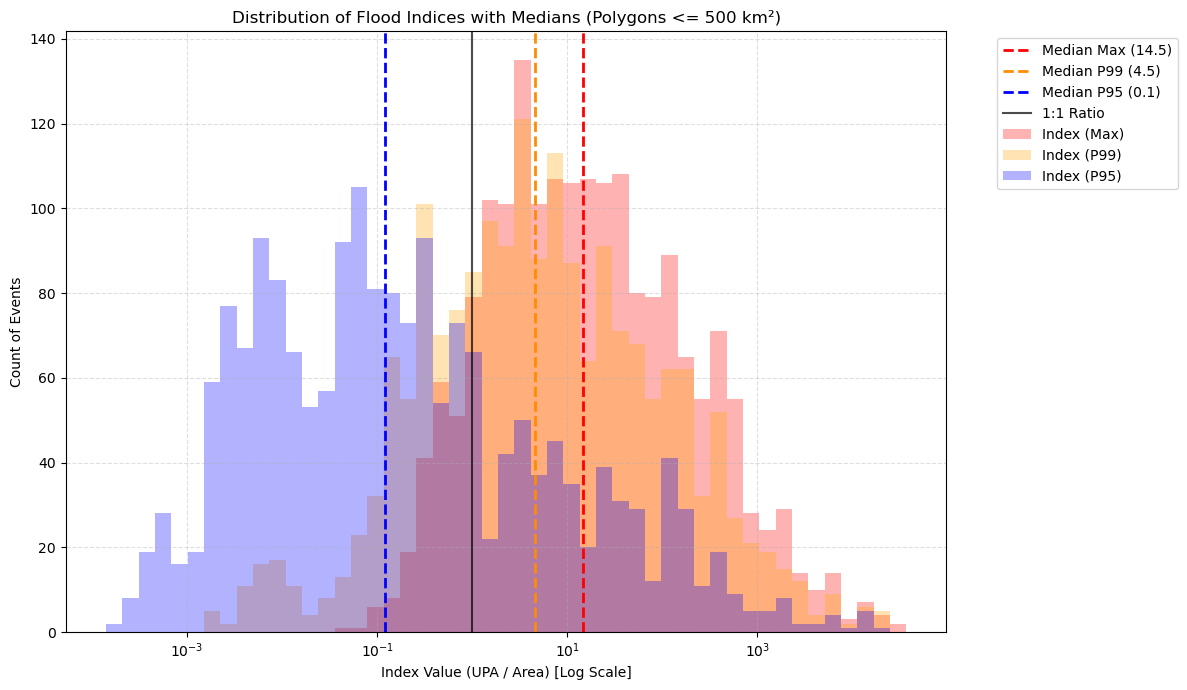

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# =========================
# 1. Filter Data & Calc Indices
# =========================
# Filter: Area <= 500 km^2
df_subset = df_pfdi_clean[df_pfdi_clean["poly_area_km2"] <= 500].copy()

# Calculate Indices (UPA / Area)
df_subset["idx_max"] = df_subset["upa_max"] / df_subset["poly_area_km2"]
df_subset["idx_p99"] = df_subset["upa_p99"] / df_subset["poly_area_km2"]
df_subset["idx_p95"] = df_subset["upa_p95"] / df_subset["poly_area_km2"]

# =========================
# 2. Calculate Medians
# =========================
med_max = df_subset["idx_max"].median()
med_p99 = df_subset["idx_p99"].median()
med_p95 = df_subset["idx_p95"].median()

print(f"Median (Max): {med_max:.2f}")
print(f"Median (P99): {med_p99:.2f}")
print(f"Median (P95): {med_p95:.2f}")

# =========================
# 3. Plot
# =========================
plt.figure(figsize=(12, 7))

# Define bins (logarithmic scale)
min_val = min(df_subset["idx_p95"].min(), df_subset["idx_max"].min())
max_val = max(df_subset["idx_p95"].max(), df_subset["idx_max"].max())
if min_val <= 0: min_val = 0.001 
bins = np.logspace(np.log10(min_val), np.log10(max_val), 50)

# --- Histograms ---
plt.hist(df_subset["idx_max"], bins=bins, alpha=0.3, color='red', label='Index (Max)')
plt.hist(df_subset["idx_p99"], bins=bins, alpha=0.3, color='orange', label='Index (P99)')
plt.hist(df_subset["idx_p95"], bins=bins, alpha=0.3, color='blue', label='Index (P95)')

# --- Median Lines ---
# Red Line for Max Median
plt.axvline(med_max, color='red', linestyle='--', linewidth=2, label=f'Median Max ({med_max:.1f})')

# Orange Line for P99 Median
plt.axvline(med_p99, color='darkorange', linestyle='--', linewidth=2, label=f'Median P99 ({med_p99:.1f})')

# Blue Line for P95 Median
plt.axvline(med_p95, color='blue', linestyle='--', linewidth=2, label=f'Median P95 ({med_p95:.1f})')

# --- Reference Line (Index = 1) ---
plt.axvline(x=1, color='black', linestyle='-', linewidth=1.5, alpha=0.7, label='1:1 Ratio')

# =========================
# 4. Formatting
# =========================
plt.xscale("log")
plt.xlabel("Index Value (UPA / Area) [Log Scale]")
plt.ylabel("Count of Events")
plt.title("Distribution of Flood Indices with Medians (Polygons <= 500 km²)")

# Place legend outside to avoid cluttering the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.grid(True, which="both", linestyle="--", alpha=0.4)
plt.tight_layout() # Adjust layout to make room for legend

plt.show()

In [12]:
# ============================================
# 0) IMPORTS
# ============================================
import pandas as pd
import geopandas as gpd
import folium
import branca.colormap as cm
from shapely import wkt
import numpy as np


# ============================================
# 1) PATHS
# ============================================
CSV_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\pfdi_merit_outputs\pfdi_stats_batch_0000.csv"
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"


# ============================================
# 2) LOAD DATA
# ============================================
df_pfdi = pd.read_csv(CSV_PATH)

df_orig = pd.read_pickle(PKL_PATH)
df_orig["event_id"] = df_orig.index.astype(int)

# Merge PFDI back to original Chronicle data
df = df_orig.merge(df_pfdi, on="event_id", how="inner")


# ============================================
# 3) BUILD GEODATAFRAME
# ============================================
gdf = gpd.GeoDataFrame(
    df,
    geometry=df["geometry_wkt"].apply(wkt.loads),
    crs="EPSG:4326"
)

# Remove invalid / missing PFDI
gdf = gdf.dropna(subset=["PFDI"]).copy()

# Log-transform for visualization
gdf["logPFDI"] = np.log10(gdf["PFDI"])


# ============================================
# 4) SELECT DIAGNOSTIC SUBSET
#    - low / mid / high PFDI
# ============================================
N_PER_GROUP = 20

low = gdf.nsmallest(N_PER_GROUP, "PFDI")
high = gdf.nlargest(N_PER_GROUP, "PFDI")

mid = gdf.iloc[
    (gdf["PFDI"] - gdf["PFDI"].median())
    .abs()
    .argsort()[:N_PER_GROUP]
]

gdf_vis = pd.concat([low, mid, high], ignore_index=True)

print("Visualization subset size:", len(gdf_vis))
print(
    gdf_vis[["PFDI", "poly_area_km2", "urban_percentage"]]
    .describe()
)


# ============================================
# 5) CREATE INTERACTIVE MAP
# ============================================
center_geom = gdf_vis.geometry.centroid.unary_union.centroid
m = folium.Map(
    location=[center_geom.y, center_geom.x],
    zoom_start=11,
    tiles="OpenStreetMap"
)

# Color scale (log10 PFDI)
cmap = cm.linear.RdYlBu_11.scale(
    gdf_vis["logPFDI"].min(),
    gdf_vis["logPFDI"].max()
)

def style_fn(feature):
    val = feature["properties"]["logPFDI"]
    return {
        "fillColor": cmap(val),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.6
    }

folium.GeoJson(
    gdf_vis,
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=[
            "PFDI",
            "poly_area_km2",
            "urban_percentage"
        ],
        aliases=[
            "PFDI",
            "Area (km²)",
            "Urban (%)"
        ],
        localize=True
    )
).add_to(m)

cmap.caption = "log10(PFDI)  —  Pluvial ↔ Fluvial dominance"
cmap.add_to(m)


# ============================================
# 6) DISPLAY MAP
# ============================================
m


Visualization subset size: 60
               PFDI  poly_area_km2  urban_percentage
count     60.000000      60.000000         60.000000
mean    2347.857463     962.429637         11.057808
std     4617.128467    1430.514618         11.178726
min        0.000025       0.030639          0.489684
25%        0.000054       0.975155          1.636321
50%        0.086480       9.417715          8.443797
75%     2311.123844    2372.771362         18.661740
max    23162.768818    4384.059435         41.797801


C:\Users\raznu\AppData\Local\Temp\ipykernel_30036\1489444000.py:74: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  center_geom = gdf_vis.geometry.centroid.unary_union.centroid


In [ ]:
W

Rows for plotting: 2000
               PFDI  poly_area_km2
count   2000.000000    2000.000000
mean      94.211749     145.883876
std      894.893406     541.371351
min        0.000025       0.014797
25%        0.006618       1.195031
50%        0.086758       6.939893
75%        1.318728      33.559510
max    23162.768818    4795.628839


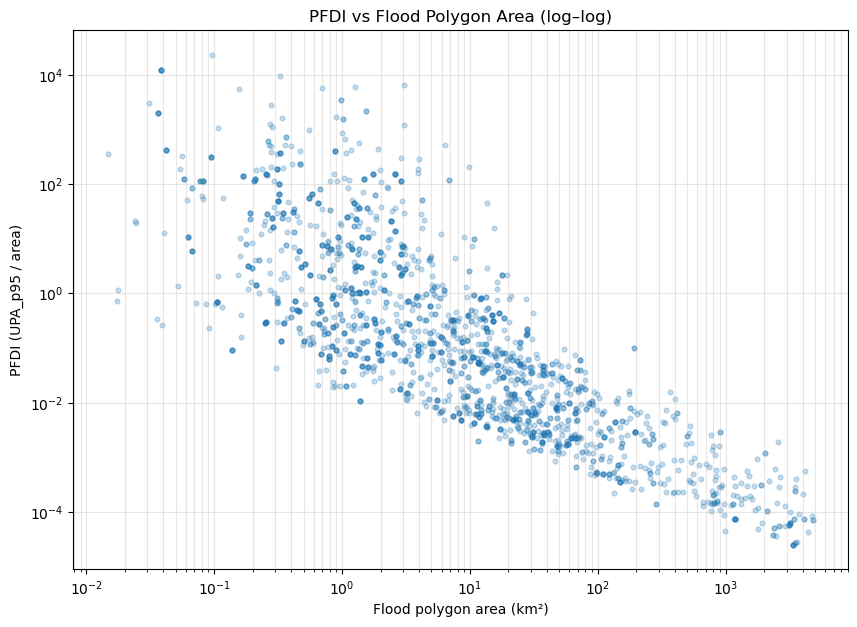

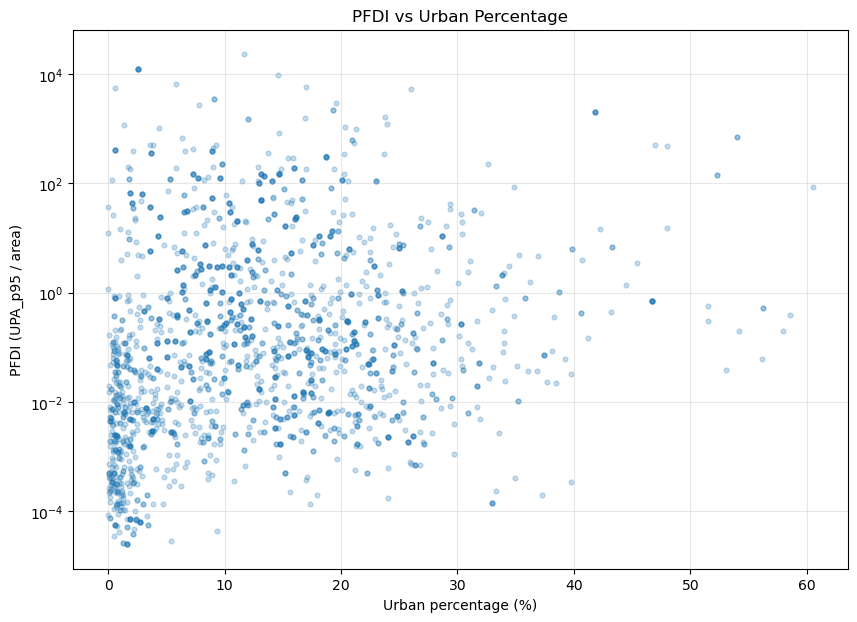

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# =========================
# Paths (your local machine)
# =========================
CSV_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\pfdi_merit_outputs\pfdi_stats_batch_0000.csv"
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"

# =========================
# Load
# =========================
df_pfdi = pd.read_csv(CSV_PATH)
df_orig = pd.read_pickle(PKL_PATH)
df_orig["event_id"] = df_orig.index.astype(int)

# Merge
df = df_orig.merge(df_pfdi, on="event_id", how="inner").copy()

# Clean
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["PFDI", "poly_area_km2"]).copy()

# Avoid zeros for log plots
df = df[(df["PFDI"] > 0) & (df["poly_area_km2"] > 0)].copy()

print("Rows for plotting:", len(df))
print(df[["PFDI", "poly_area_km2"]].describe())

# =========================
# 1) PFDI vs Area (log-log)
# =========================
plt.figure(figsize=(10, 7))
plt.scatter(df["poly_area_km2"].values, df["PFDI"].values, alpha=0.25, s=12)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Flood polygon area (km²)")
plt.ylabel("PFDI (UPA_p95 / area)")
plt.title("PFDI vs Flood Polygon Area (log–log)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

# =========================
# 2) PFDI vs Urban % (log-y), if exists
# =========================
if "urban_percentage" in df.columns:
    df2 = df.dropna(subset=["urban_percentage"]).copy()
    plt.figure(figsize=(10, 7))
    plt.scatter(df2["urban_percentage"].values, df2["PFDI"].values, alpha=0.25, s=12)
    plt.yscale("log")
    plt.xlabel("Urban percentage (%)")
    plt.ylabel("PFDI (UPA_p95 / area)")
    plt.title("PFDI vs Urban Percentage")
    plt.grid(True, which="both", alpha=0.3)
    plt.show()
else:
    print("Note: 'urban_percentage' column not found in the PKL.")


In [15]:
df

,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage,event_id,poly_area_km2,upa_max,upa_p95,upa_p99,PFDI
0,0,93e48341dbaa4be29a38b856d94206c5,191.436317,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.6844751 33.499789, -7.5516781 33....",4608358.0,1.531473e+08,3.009102,0,152.737360,2144.798828,0.231797,506.047577,0.001518
1,1,939149831ea34c3e94712cc42c17c46a,14.208894,v3.1,946684800.0,946684800.0,1,"POLYGON ((-7.9863739 29.745153, -7.9965878 29....",751304.0,9.880934e+06,7.603573,1,9.846162,1930.907593,24.820149,1929.830884,2.520794
2,2,931831f75479454cb3938811e64ce882,28.562733,v3.1,946684800.0,946684800.0,1,"POLYGON ((-98.97432499999999 19.337026, -98.93...",3757833.0,1.180029e+07,31.845253,2,11.730829,8171.314453,0.613581,0.613581,0.052305
3,3,91bc68dde43646289c9e75b7d59e1711,108.562378,v3.1,946684800.0,946684800.0,1,"POLYGON ((30.936502 -29.872152, 30.928104 -29....",26634641.0,1.273836e+08,20.908999,3,126.937144,4441.062012,0.377705,243.834593,0.002976
4,4,8b849511de80423f98918f55af323e7e,0.104375,v3.1,946684800.0,946684800.0,1,"POLYGON ((16.547385 38.687964, 16.549982 38.68...",49138.0,1.051849e+05,46.715826,4,0.105030,0.107175,0.073682,0.073682,0.701532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,1995,bc9db259939b4e7bbd733cddc75fd4ae,6.064658,v3.1,988675200.0,988675200.0,1,"POLYGON ((30.422276 50.489059, 30.451731 50.50...",986878.0,4.863141e+06,20.293018,1995,4.869447,12.263927,0.671918,11.538102,0.137987
1996,1996,cc7de4222d284f44875f88ec1c9e4886,39.465225,v3.1,988675200.0,988675200.0,1,"POLYGON ((37.71646 44.735583, 37.727298 44.768...",9056884.0,3.537692e+07,25.601112,1996,35.369374,84.639458,1.729812,37.736286,0.048907
1997,1997,ce5d434568224af895ac108113de7ca0,14.710346,v3.1,988675200.0,988675200.0,1,"POLYGON ((39.048374 44.12004, 39.087667 44.128...",2577571.0,1.484113e+07,17.367751,1997,14.839106,352.425598,0.082846,345.308260,0.005583
1998,1998,d4a1d64ccdc34b68b91d97921689b305,15.122304,v3.1,988675200.0,988675200.0,1,"POLYGON ((37.34507 45.276124, 37.363655 45.297...",4094533.0,2.473481e+07,16.553727,1998,24.727607,3562.722168,0.075580,3561.036632,0.003056


Rows after merge/clean: 2000
Columns available: ['upa_p95', 'upa_p99', 'upa_max', 'PFDI', 'poly_area_km2', 'urban_percentage']
       Dominance_99_95  poly_area_km2
count     2.000000e+03    2000.000000
mean      5.995916e+03     145.883876
std       7.775282e+04     541.371351
min       1.000000e+00       0.014797
25%       1.253789e+00       1.195031
50%       9.704718e+00       6.939893
75%       2.783736e+02      33.559510
max       3.345939e+06    4795.628839


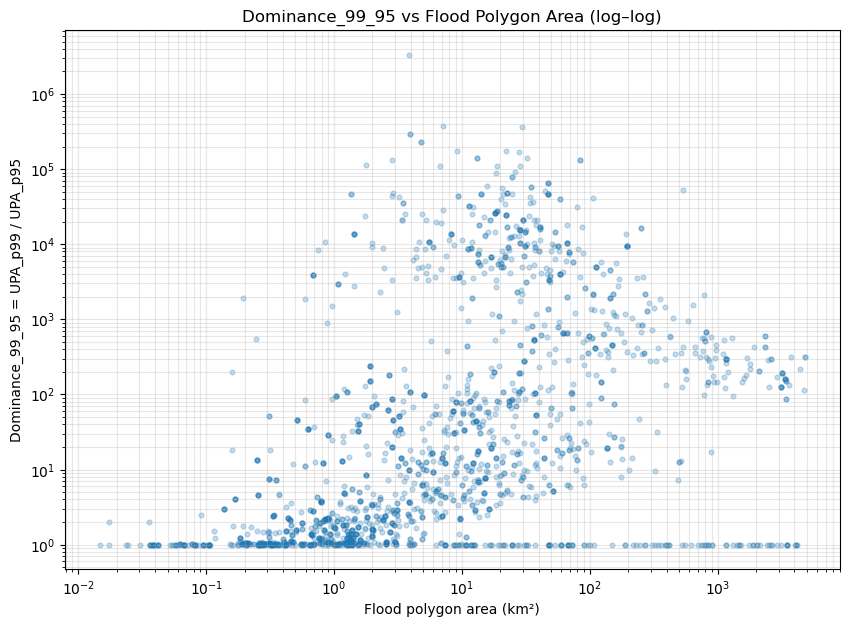

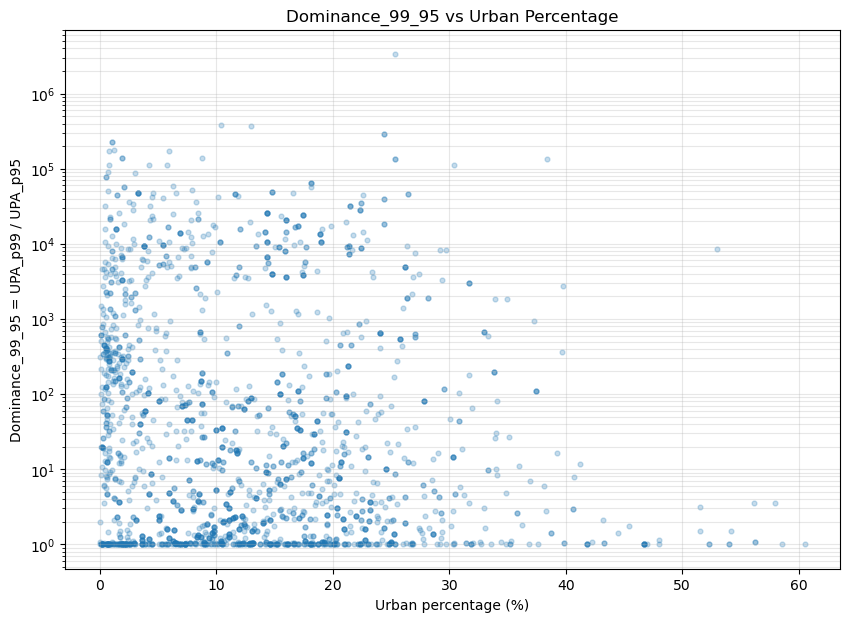

Map subset size: 60


In [8]:
# ============================================
# 0) IMPORTS
# ============================================
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt

import folium
import branca.colormap as cm
from shapely import wkt


# ============================================
# 1) PATHS
# ============================================
CSV_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\pfdi_merit_outputs\pfdi_stats_batch_0000.csv"
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"


# ============================================
# 2) LOAD + MERGE
#    - CSV: has upa_p95 / upa_p99 / upa_max (and PFDI)
#    - PKL: has geometry_wkt, urban_percentage, etc.
# ============================================
df_stats = pd.read_csv(CSV_PATH)

df_orig = pd.read_pickle(PKL_PATH)
df_orig["event_id"] = df_orig.index.astype(int)

df = df_orig.merge(df_stats, on="event_id", how="inner").copy()

# Basic cleanup
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna(subset=["poly_area_km2", "upa_p95", "upa_p99"]).copy()

# Guard against zeros for ratios/logs
df = df[(df["poly_area_km2"] > 0) & (df["upa_p95"] > 0) & (df["upa_p99"] > 0)].copy()

print("Rows after merge/clean:", len(df))
print("Columns available:", [c for c in ["upa_p95", "upa_p99", "upa_max", "PFDI", "poly_area_km2", "urban_percentage"] if c in df.columns])


# ============================================
# 3) DEFINE NEW NORMALIZED INDEX (NO AREA)
#    Dominance_99_95: tail sharpness / dominance proxy
# ============================================
df["Dominance_99_95"] = df["upa_p99"] / df["upa_p95"]

# Optional log for visualization
df["logDominance_99_95"] = np.log10(df["Dominance_99_95"])

print(df[["Dominance_99_95", "poly_area_km2"]].describe())


# ============================================
# 4) SCATTER: Dominance_99_95 vs Area (log-log)
# ============================================
plt.figure(figsize=(10, 7))
plt.scatter(df["poly_area_km2"].values, df["Dominance_99_95"].values, alpha=0.25, s=12)
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Flood polygon area (km²)")
plt.ylabel("Dominance_99_95 = UPA_p99 / UPA_p95")
plt.title("Dominance_99_95 vs Flood Polygon Area (log–log)")
plt.grid(True, which="both", alpha=0.3)
plt.show()

# Optional: Dominance vs Urban %
if "urban_percentage" in df.columns:
    df_u = df.dropna(subset=["urban_percentage"]).copy()
    plt.figure(figsize=(10, 7))
    plt.scatter(df_u["urban_percentage"].values, df_u["Dominance_99_95"].values, alpha=0.25, s=12)
    plt.yscale("log")
    plt.xlabel("Urban percentage (%)")
    plt.ylabel("Dominance_99_95 = UPA_p99 / UPA_p95")
    plt.title("Dominance_99_95 vs Urban Percentage")
    plt.grid(True, which="both", alpha=0.3)
    plt.show()


# ============================================
# 5) MAP: diagnostic subset (low / mid / high)
#    - single interactive map, ~60 polygons total
# ============================================
gdf = gpd.GeoDataFrame(
    df,
    geometry=df["geometry_wkt"].apply(wkt.loads),
    crs="EPSG:4326"
)

gdf = gdf.dropna(subset=["Dominance_99_95"]).copy()

N_PER_GROUP = 20

low = gdf.nsmallest(N_PER_GROUP, "Dominance_99_95")
high = gdf.nlargest(N_PER_GROUP, "Dominance_99_95")

mid = gdf.iloc[
    (gdf["Dominance_99_95"] - gdf["Dominance_99_95"].median())
    .abs()
    .argsort()[:N_PER_GROUP]
]

gdf_vis = pd.concat([low, mid, high], ignore_index=True).copy()
gdf_vis["logDominance_99_95"] = np.log10(gdf_vis["Dominance_99_95"])

print("Map subset size:", len(gdf_vis))

# Build map (centered on the subset)
center_geom = gdf_vis.geometry.centroid.unary_union.centroid
m = folium.Map(
    location=[center_geom.y, center_geom.x],
    zoom_start=11,
    tiles="OpenStreetMap"
)

# Color scale on log10 values (more stable visually)
cmap = cm.linear.RdYlBu_11.scale(
    gdf_vis["logDominance_99_95"].min(),
    gdf_vis["logDominance_99_95"].max()
)

def style_fn(feature):
    val = feature["properties"]["logDominance_99_95"]
    return {
        "fillColor": cmap(val),
        "color": "black",
        "weight": 1,
        "fillOpacity": 0.6
    }

tooltip_fields = ["Dominance_99_95", "poly_area_km2"]
tooltip_aliases = ["Dominance_99_95 (p99/p95)", "Area (km²)"]

# Add urban % if present
if "urban_percentage" in gdf_vis.columns:
    tooltip_fields.append("urban_percentage")
    tooltip_aliases.append("Urban (%)")

folium.GeoJson(
    gdf_vis,
    style_function=style_fn,
    tooltip=folium.GeoJsonTooltip(
        fields=tooltip_fields,
        aliases=tooltip_aliases,
        localize=True
    )
).add_to(m)

cmap.caption = "log10(Dominance_99_95)  —  lower = more diffuse, higher = more channel-dominant"
cmap.add_to(m)

m


In [1]:
import ee
ee.Authenticate()


Enter verification code: 4/1ATX87lPBfGwuUE9Ma9Rmdm_UAQqhLe-fsA-vQvhHYHs3Uh80IvVJM-y7hj0

Successfully saved authorization token.


In [8]:
# ============================================
# 0) IMPORTS
# ============================================
import pandas as pd
import geopandas as gpd
from shapely import wkt

import ee
import geemap


# ============================================
# 1) CONFIGURATION
# ============================================
PKL_PATH = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl"

# Column name in your PKL containing WKT geometry.
GEOM_WKT_COL = "geometry_wkt"

# A small sample size for testing the end-to-end pipeline before scaling up
SAMPLE_SIZE = 200

# MERIT Hydro dataset ID and band
MERIT_IMAGE_ID = "MERIT/Hydro/v1_0_1"
UPA_BAND = "upa"  # upstream drainage area (km^2)


# ============================================
# 2) LOAD & PREPARE YOUR CHRONICLE DATA
# ============================================
df = pd.read_pickle(PKL_PATH)

# Ensure geometry column exists
if GEOM_WKT_COL not in df.columns:
    raise ValueError(
        f"Column '{GEOM_WKT_COL}' not found. Available columns: {list(df.columns)}"
    )

# Build GeoDataFrame
gdf = gpd.GeoDataFrame(
    df.copy(),
    geometry=df[GEOM_WKT_COL].apply(wkt.loads),
    crs="EPSG:4326"
)

# Create a stable event_id (use index)
gdf["event_id"] = gdf.index.astype(int)

# Basic geometry cleanup
# buffer(0) can fix minor self-intersections; it may fail for some geometries, so we do it safely.
def _fix_geom(geom):
    try:
        if geom is None:
            return None
        return geom.buffer(0)
    except Exception:
        return geom

gdf["geometry"] = gdf["geometry"].apply(_fix_geom)
gdf = gdf[gdf.geometry.notnull()].copy()

print("Chronicle GeoDataFrame loaded.")
print("Rows:", len(gdf))
print("CRS:", gdf.crs)
print(gdf[["event_id"]].head())


# ============================================
# 3) AUTHENTICATE & INITIALIZE EARTH ENGINE
# ============================================
try:
    ee.Initialize()
    print("Earth Engine initialized.")
except Exception:
    print("Earth Engine not initialized. Running authentication...")
    ee.Authenticate()
    ee.Initialize()
    print("Earth Engine authenticated and initialized.")


# ============================================
# 4) LOAD MERIT HYDRO (UPA) AND DISPLAY ON A MAP (ONCE)
# ============================================
merit = ee.Image(MERIT_IMAGE_ID)
upa = merit.select(UPA_BAND)

# Create a map for quick intuition
m = geemap.Map(center=(20, 0), zoom=2)

# Visualization parameters
# UPA can span many orders of magnitude; log helps visualization.
upa_log = upa.log10()

vis_params = {
    "min": 0,
    "max": 5,  # log10 scale: 10^0 to 10^5 km^2
}

m.addLayer(upa_log, vis_params, "MERIT Hydro - log10(UPA)")
m.addLayerControl()
m


# ============================================
# 5) RUN A SMALL TEST BATCH (RECOMMENDED)
# ============================================
gdf_sample = gdf.sample(SAMPLE_SIZE, random_state=42).copy()

# Keep only the minimal columns needed for upload to EE
gdf_sample_min = gdf_sample[["event_id", "geometry"]].copy()

print(f"Using a sample of {len(gdf_sample_min)} polygons for a test run.")


# ============================================
# 6) CONVERT SAMPLE POLYGONS TO EE FEATURECOLLECTION
# ============================================
fc = geemap.geopandas_to_ee(gdf_sample_min)

# Quick sanity check
print("EE FeatureCollection size:", fc.size().getInfo())


# ============================================
# 7) COMPUTE ZONAL STATS (MAX, P95, P99) OF UPA WITHIN EACH POLYGON
# ============================================
reducer = ee.Reducer.max().combine(
    ee.Reducer.percentile([95, 99]),
    sharedInputs=True
)

# MERIT Hydro is ~3 arc-sec (~90m). Use 90m scale.
stats_fc = upa.reduceRegions(
    collection=fc,
    reducer=reducer,
    scale=90
)

# Convert results back to a pandas DataFrame
# Some geemap versions do not have ee_to_pandas; use ee_to_df instead.
if hasattr(geemap, "ee_to_df"):
    df_stats = geemap.ee_to_df(stats_fc)
elif hasattr(geemap, "ee_to_pandas"):
    df_stats = geemap.ee_to_pandas(stats_fc)
else:
    # Fallback: use Earth Engine API (slower, but robust)
    features = stats_fc.getInfo().get("features", [])
    df_stats = pd.DataFrame([f.get("properties", {}) for f in features])

print("Returned stats columns:", list(df_stats.columns))
display(df_stats.head())


# ============================================
# 8) ADD POLYGON AREA AND DERIVED RATIO
# ============================================
gdf_area = gdf_sample_min.to_crs("EPSG:6933").copy()
gdf_area["poly_area_km2"] = gdf_area.geometry.area / 1_000_000.0
df_area = gdf_area[["event_id", "poly_area_km2"]].copy()

# Merge stats + area
out = df_stats.merge(df_area, on="event_id", how="left")

# MERIT UPA stats fields are expected like "upa_max", "upa_p95", "upa_p99".
# If naming differs, inspect df_stats.columns and adjust here.
if "upa_max" in out.columns:
    out["upa_max_to_area_ratio"] = out["upa_max"] / out["poly_area_km2"]
else:
    print("Warning: 'upa_max' not found in output columns. Check column names above.")

display(out.head())


# ============================================
# 9) MERGE BACK INTO YOUR ORIGINAL DATAFRAME (FOR THE SAMPLE)
# ============================================
df_sample_enriched = gdf_sample.drop(columns=["geometry"]).merge(out, on="event_id", how="left")

print("Enriched sample:")
display(df_sample_enriched.head())


# ============================================
# 10) NEXT STEP (SCALING UP)
# ============================================
print(
    "\nNext step:\n"
    "- If the sample run works, do NOT convert the full 882,972 polygons via geemap in one shot.\n"
    "- Either upload polygons to GEE as an Asset OR process in batches (e.g., 2,000-10,000 at a time).\n"
)


Chronicle GeoDataFrame loaded.
Rows: 882972
CRS: EPSG:4326
   event_id
0         0
1         1
2         2
3         3
4         4
Earth Engine initialized.
Using a sample of 200 polygons for a test run.
EE FeatureCollection size: 200
Returned stats columns: ['event_id', 'max', 'p95', 'p99']


,event_id,max,p95,p99
0,817395,0.775346,0.350160,0.733661
1,214476,51.656307,36.687677,39.553326
2,145026,5.370650,0.511030,2.123826
3,517053,45543.605469,0.505570,0.505570
4,605645,241.660202,1.402649,31.462908


,event_id,max,p95,p99,poly_area_km2
0,817395,0.775346,0.350160,0.733661,0.722302
1,214476,51.656307,36.687677,39.553326,8.273045
2,145026,5.370650,0.511030,2.123826,14.435320
3,517053,45543.605469,0.505570,0.505570,204.951064
4,605645,241.660202,1.402649,31.462908,461.085999


Enriched sample:


,Unnamed: 0,uuid,area_km2,version,start_time,end_time,duration_days,geometry_wkt,urban_built_up_area_m2,polygon_total_area_m2,urban_percentage,event_id,max,p95,p99,poly_area_km2
0,817395,c9a3bf5d24ed402aa23b106d807dab5f,0.826844,v3.1,1.747526e+09,1.747786e+09,4,"POLYGON ((77.617199 12.880569, 77.619275 12.88...",309237.0,7.266732e+05,42.555168,817395,0.775346,0.350160,0.733661,0.722302
1,214476,06b210e7be344d4c8ded499e7a24ca5f,9.094827,v3.1,1.501373e+09,1.501459e+09,2,"POLYGON ((-84.21356900000001 10.00181, -84.226...",2269496.0,8.325536e+06,27.259459,214476,51.656307,36.687677,39.553326,8.273045
2,145026,f13346a19f0148758b7f6e90fa12fe52,10.018100,v3.1,1.444954e+09,1.445386e+09,6,"POLYGON ((-94.697504 18.002704, -94.670743 18....",1482286.0,1.451547e+07,10.211769,145026,5.370650,0.511030,2.123826,14.435320
3,517053,6296e56a9a7e4a55b34aaf02e3441906,200.028078,v3.1,1.655251e+09,1.655251e+09,1,"MULTIPOLYGON (((38.865091 45.037124, 38.985043...",46790769.0,2.049897e+08,22.825908,517053,45543.605469,0.505570,0.505570,204.951064
4,605645,9cc2f50ec6cb407fba765137e661d89d,425.966194,v3.1,1.687738e+09,1.687738e+09,1,"MULTIPOLYGON (((-85.27982 9.921947100000001, -...",983860.0,4.639786e+08,0.212049,605645,241.660202,1.402649,31.462908,461.085999



Next step:
- If the sample run works, do NOT convert the full 882,972 polygons via geemap in one shot.
- Either upload polygons to GEE as an Asset OR process in batches (e.g., 2,000-10,000 at a time).



# Imports & Configuration

In [8]:
import pandas as pd
import geopandas as gpd
from shapely import wkt, geometry
from shapely.geometry import box
import rasterio
from rasterstats import zonal_stats
import numpy as np
import folium
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import math
# --- CONFIGURATION ---

# File Paths
chronicle_ds_csv_path = r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_preliminary_huji.csv"
ghs_urban_raster_path = r"D:\Development\RESEARCH\Raanana\data\esa_worldcover\GHS_BUILT_S_E2020_GLOBE_R2023A_54009_100_V1_0.tif"

# Processing Settings
# Set to an integer (e.g., 10000) for testing, or None for full dataset
SAMPLE_SIZE = None

# Data Loading & Processing

In [ ]:
if SAMPLE_SIZE:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path, nrows=SAMPLE_SIZE)
else:
    chronicle_raw_df = pd.read_csv(chronicle_ds_csv_path)

# 2. Parse Geometries
print("Parsing WKT geometries...")
chronicle_raw_df['geometry'] = chronicle_raw_df['geometry_wkt'].apply(wkt.loads)

# 3. Create GeoDataFrame
chronicle_gdf = gpd.GeoDataFrame(chronicle_raw_df, geometry='geometry')
chronicle_gdf.set_crs(epsg=4326, inplace=True)

# 4. Reproject
with rasterio.open(ghs_urban_raster_path) as src:
    ghs_raster_crs = src.crs
    ghs_nodata_value = src.nodata
    print(f"Raster CRS: {ghs_raster_crs}")
    
    print("Reprojecting polygons...")
    chronicle_projected_gdf = chronicle_gdf.to_crs(ghs_raster_crs)

# 5. Calculate Zonal Statistics (WITH PROGRESS TRACKING)
print("Calculating zonal stats in chunks...")

# -- PROGRESS LOGIC START --
total_rows = len(chronicle_projected_gdf)
# We want 10 updates, so we divide total rows by 10
chunk_size = math.ceil(total_rows / 10) 
all_stats = []

# Iterate through the DataFrame in chunks
for i in range(0, total_rows, chunk_size):
    # Slice the dataframe
    subset = chronicle_projected_gdf.iloc[i : i + chunk_size]
    
    # Run stats just for this chunk
    chunk_stats = zonal_stats(
        subset,
        ghs_urban_raster_path,
        stats=['sum'],
        nodata=ghs_nodata_value
    )
    
    # Accumulate results
    all_stats.extend(chunk_stats)
    
    # Calculate and print progress
    current_row = min(i + chunk_size, total_rows)
    percent_complete = int((current_row / total_rows) * 100)
    print(f"{percent_complete}% complete... ({current_row}/{total_rows})")

# Convert accumulated list to DataFrame
urban_stats_df = pd.DataFrame(all_stats)
# -- PROGRESS LOGIC END --

# 6. Calculate Urban Percentage
print("Calculating percentages...")
chronicle_projected_gdf['urban_built_up_area_m2'] = urban_stats_df['sum'].fillna(0)
chronicle_projected_gdf['polygon_total_area_m2'] = chronicle_projected_gdf.area

chronicle_projected_gdf['urban_percentage'] = np.where(
    chronicle_projected_gdf['polygon_total_area_m2'] > 0,
    (chronicle_projected_gdf['urban_built_up_area_m2'] / chronicle_projected_gdf['polygon_total_area_m2']) * 100,
    0
)

# 7. Final Clean DataFrame
chronicle_urban_df = pd.DataFrame(chronicle_projected_gdf.drop(columns='geometry'))

print(f"--- Done! Processed {len(chronicle_urban_df)} records. ---")

## Save as a pickle

In [9]:
# Save the DataFrame to a pickle file at the specified path
# chronicle_urban_df.to_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

In [10]:
# Load the DataFrame from the specified path
chronicle_urban_df = pd.read_pickle(r"D:\Development\RESEARCH\urban_flood_database\chronicle\chronicle_urban_df.pkl")

In [13]:
# 1. Filter rows with percentage > 100
anomalies = thresh_chronicle_urban_df[thresh_chronicle_urban_df['urban_percentage'] > 100]
count = len(anomalies)


print(f"Total events checked: {len(thresh_chronicle_urban_df)}")
print(f"Events with > 100% urban area: {count}")

if count > 0:
    max_val = anomalies['urban_percentage'].max()
    print(f"Highest value found: {max_val:.2f}%")
    
    print("\nTop 5 Anomalies (Preview):")
    # Show UUID, Percentage, and Total Area (often happens in very small polygons)
    print(anomalies[['uuid', 'urban_percentage', 'polygon_total_area_m2']].head())
else:
    print("Status: OK. No values above 100% found.")

--- Data Integrity Check ---
Total events checked: 214204
Events with > 100% urban area: 0
Status: OK. No values above 100% found.


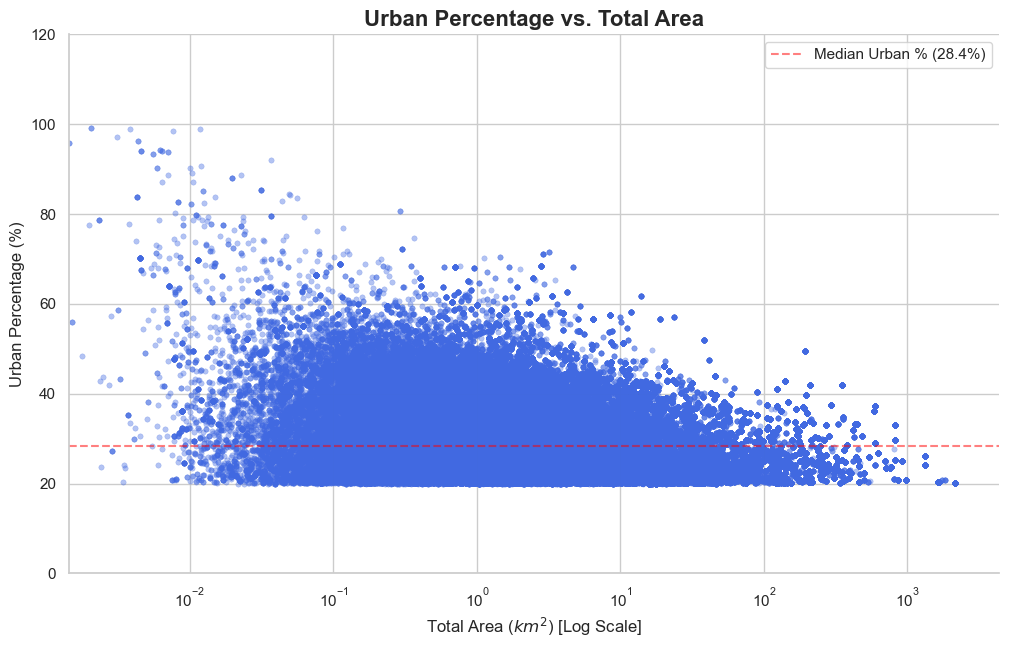

In [14]:

# 1. Create a copy and convert area to km² for better readability
# (1 km² = 1,000,000 m²)
df_plot = thresh_chronicle_urban_df.copy()
df_plot['area_km2'] = df_plot['polygon_total_area_m2'] / 1_000_000

# 2. Setup the figure
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 7))

# 3. Create Scatter Plot
sns.scatterplot(
    data=df_plot,
    x='area_km2',
    y='urban_percentage',
    alpha=0.4,       # Transparency helps visualize overlapping points
    edgecolor=None,  # Removes borders from dots for a cleaner look
    s=15,            # Dot size
    color='royalblue'
)

# 4. Set Log Scale for X-axis (Crucial for Area distribution)
plt.xscale('log')

# 5. Set limits and styling
plt.ylim(0, 120)
plt.xlim(left=df_plot['area_km2'].min()) # Start from the smallest polygon

plt.title('Urban Percentage vs. Total Area', fontsize=16, fontweight='bold')
plt.xlabel('Total Area ($km^2$) [Log Scale]', fontsize=12)
plt.ylabel('Urban Percentage (%)', fontsize=12)

# 6. Add a visual helper line (e.g., median urban percentage)
median_val = df_plot['urban_percentage'].median()
plt.axhline(median_val, color='red', linestyle='--', alpha=0.5, label=f'Median Urban % ({median_val:.1f}%)')
plt.legend()

sns.despine()
plt.show()